# Data analysis with SciAnalysis

last updated: 2022 Nov 3

### Section A: SciAnalysis

- A1. <span style='background :yellow' > __Tutorial to SciAnalysis__</span> (stadard routines: circular_average, qr_image, etc): If you are not familiar with SciAnalysis, go through Section A1 carefully, this will help you understand the code and run the routine data reduction/analysis. 
<span style='background :yellow' > __Note__</span> that the parameters in this jupyter notebook might not be correct for your experiment, check your data and runXS.py file. If you are comfortable with python, you should run the runXS.py (in the analysis folder) file directly.
- A2. Stitching SAXS or WAXS raw data
- A3. Background subtraction  
- A4. Adjust fitting: load DAT file and fit
- A5. Load results and plot: Load 2D, XM (roi, fitting result)

### Section B: Experiment (RHeadrick3)

- B1. Define an 'experiment': for comparimg multiple measuremeants e.g. mapping
- B2. Plot


--------------------------------------

# &#9635; Section A: SciAnalysis

## &#9632; A1. Tutorial to SciAnalysis

Load raw data (TIFF) and do analysis

### A1.1 Download SciAnalysis at: https://github.com/CFN-softbio/SciAnalysis

### A1.2 Put your download path for SciAnalysis_PATH:

In [7]:
#%matplotlib nbagg

# Imports
########################################
import sys, os, time, glob, imageio

#SciAnalysis_PATH='/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/' ### Specify this
SciAnalysis_PATH = '/home/etsai/BNL/Users/software/SciAnalysis/'
SciAnalysis_PATH in sys.path or sys.path.append(SciAnalysis_PATH)

from SciAnalysis import tools
from SciAnalysis.XSAnalysis.Data import *
from SciAnalysis.XSAnalysis import Protocols


### A1.3. Specify beamline parameters 

Specify parameters based on SAXS/WAXS and beamline configuration.

In [8]:
# Experimental parameters
########################################
## CMS
if 1: ### RHeadrick3
    calibration = Calibration(wavelength_A=0.7293) # 17 keV
    calibration.set_image_size(981, height=1043) # Pilatus1M
    calibration.set_pixel_size(pixel_size_um=172.0)
    calibration.set_beam_position(473, 1043-387-15+11) #Headrick3, 2022 Oct 27, 17kev_normal_WAXSx-225_y22_z-142_x0.000_y0.000_10.00s_762645_waxs   
    
    calibration.set_distance(0.261)
    mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
    mask = Mask(mask_dir+'Dectris/Pilatus800k_gaps-mask.png')
    mask.load(mask_dir+'NSLSII_11BM_CMS/Pilatus800k_CMS_badpixels-mask.png ')
    
if 0:
    # Custom Dectris Pilatus 800k (lower-left modules removed)
    calibration = Calibration(wavelength_A=0.9184) # 13.5 keV
    calibration.set_image_size(981, height=1043) # Pilatus1M
    calibration.set_pixel_size(pixel_size_um=172.0)
    calibration.set_beam_position(475, 1043-386) 

    calibration.set_distance(0.259)

    mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
    mask = Mask(mask_dir+'Dectris/Pilatus800k_gaps-mask.png')
    mask = Mask(mask_dir+'NSLSII_11BM_CMS/Pilatus800k_CMS_badpixels-mask.png')

## SMI
if 0:
    calibration = Calibration(wavelength_A=0.770088) # 16.1 keV
    calibration.set_image_size(981, height=1043) 
    calibration.set_pixel_size(pixel_size_um=172.0)
    calibration.set_distance(8.320) # 8.300 nominal detector distance

    ## With AgBH
    calibration.set_distance(8.300) # 8.300 nominal detector distance
    calibration.set_beam_position(492, 557) #2022 TSAXS, VS    ###Choose the one you need
    #calibration.set_beam_position(492, 557+145) #2022 GISAXS, HE   ###Choose the one you need

    mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
    mask = Mask(mask_dir+'Dectris/Pilatus1M_main_gaps-mask.png')
    mask.load('./mask_badpixel3.png')

Couldn't identify mask format for /home/etsai/BNL/Users/software/SciAnalysis//SciAnalysis/XSAnalysis/masks/NSLSII_11BM_CMS/Pilatus800k_CMS_badpixels-mask.png .


(Optional: If direct beam measurement is available, use that for the beam center, else use AgBH)

In [ ]:
#### If direct beam measurement is available, use that for the beam center, else use AgBH

EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2022_3/JChoi/saxs/'  
pattern = '*DirectBeam*'
infiles = glob.glob(os.path.join(EXPR_DIR+'raw/', pattern+'.tiff'))
print(infiles)

data = Data2DScattering()
data.load(infiles[0])
img = data.data
#img[0:400] = 0
#plt.figure(); plt.imshow(np.log10(img))
beam_center = [np.argmax(np.max(img,0)), np.argmax(np.max(img,1))]
print('Beam center = {}'.format(beam_center))

### A1.4. Specify data path and analysis parameters

Specify data directory (source_dir) and where you want to save the outputs (output_dir).

#### Use 'pattern' to specify the files you want to analyze. Can start with one specific file of interest to determine the analysis protocal and parameters (Sections A1.4 and A1.5), and then process all data.

Specify the analysis protocal to use, e.g.
- circular average integrate over the entire ring, and outputs Intensity vs. q in PNG and also in DAT
- sector_average(name = 'sector_average_angle60_d10', angle=60, dangle=10) outputs the integration over dangle 10deg, with center at angle 60 (twelve oclock is 0 degree, goes clock-wise, so 60deg is two olock direction). Outputs are stored under the folder 'sector_average_angle60_d10'. Changing the name can be useful if you want different sector_average analysis.
- See Readme in https://github.com/CFN-softbio/SciAnalysis


In [17]:
# Files to analyze
########################################
#EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2022_3/JHidalgo/waxs/'  ### CHANGE THIS
EXPR_DIR = '/home/etsai/BNL/Users/CMS/2022C3/RHeadrick3/waxs/'
source_dir = EXPR_DIR + 'raw/'   ### CHANGE THIS
output_dir = EXPR_DIR + 'analysis/'   ### CHANGE THIS

# patterns = ['*117840*','*117642*','*117644*','*117830*','*117832*'] ### CHANGE THIS
patterns = ['*B6_N3_Trans3_map_vac_x-1.410_y-1.050_2.00s_763434*'] ### CHANGE THIS


# Analysis to perform
########################################

load_args = { 'calibration' : calibration, 
             'mask' : mask,
             #'rot180' : False,
             #'flip' : False,
             }
run_args = { 'verbosity' : 3,
            'fittype': 'voigt',
            }

run_args = { 'verbosity' : 3,
             'rcParams': {'axes.labelsize': 25, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 
                         'xtick.major.pad': 10, 'ytick.major.pad': 10, },
            'fittype': 'voigt',
            }

process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)

protocols = [
    #Protocols.calibration_check(show=False, AgBH=True, q0=0.1076, dq=0.005, num_rings=10, ztrim=[0.2, 0.01], dpi=300) ,
    #Protocols.circular_average(name='circular_average', ylog=True, plot_range=[0, 4.0, 5, None], gridlines=True, label_filename=True)  , #'csv'
    
    #Protocols.qr_image(blur=None, colorbar=True, save_results=['npz'], plot_buffers = [0.1, 0.1, 0.1, 0.1], transparent=False, label_filename=True) ,
    #Protocols.thumbnails(name='thumbnails_vgehdr', crop=None, resize=0.5, cmap=cmap_vge_hdr, ztrim=[0.02, 0.001]) , # Pilatus800k

    #Protocols.circular_average_q2I_fit(name='circular_fit_compare3', plot_range=[1.2, 1.8, -0.5, 2], qn_power=0.0, trim_range=[0.1, 3.5], fit_range=[1.4-0.04, 1.44+0.07], num_curves=1, q0=[1.415], sigma=0.02, gamma=0.02, show_curves=1, label_filename=True), 
   
    #Protocols.q_phi_image(bins_relative=0.25, plot_range=[0, 3.5, -90, +90],transparent=False),
    
    Protocols.roi(show_region=0, qx=0.5, dqx=0.02, qz=2.2, dqz=0.02, prepend='stats_'),
    Protocols.q_image(blur=None, colorbar=True, save_results=['npz'], transparent=False, label_filename=True, plot_buffers = [0.2, 0.1, 0.2, 0.1]),
     
    ]

### A1.5. Apply analysis 

- Run this step to do the analysis. Repeat Sections A1.4 and A1.5 to adjust protocoal parameters and apply analysis.

- If force=1, it will do analysis and overwrite old analysis results. 

- If the last line (process.monitor_loop) is used, it will run real-time analysis, ie, it keeps on checking if there are new files in the source_dir to apply the analysis protocals, force=0 in this case to process only new data.

In [18]:
# Run
########################################
t0 = time.time()

for pattern in patterns:   
    infiles = glob.glob(os.path.join(source_dir, pattern+'.tiff')); 
    infiles.sort()    
    
    print('Processing {} infiles...'.format(len(infiles)))
    process.run(infiles, protocols, output_dir=output_dir, force = 1) ### CHANGE THIS: force=0 or 1

print('===== Process Time: {:.1f} min ====='.format((time.time()-t0)/60))


########################################
# This is typically only used at the beamline (it loops forever, watching for new files).
#process.monitor_loop(source_dir=source_dir, pattern='*.tiff', protocols=protocols, output_dir=output_dir, force=False)



Processing 1 infiles...
Running roi for B6_N3_Trans3_map_vac_x-1.410_y-1.050_2.00s_763434_waxs
ROI stats:
{'qx': 0.5, 'dqx': 0.02, 'qz': 2.2, 'dqz': 0.02, 'stats_max': 118.0, 'stats_min': 68.0, 'stats_average': 92.48214285714286, 'stats_std': 9.699026224001951, 'stats_N': 56, 'stats_total': 5179.0, 'stats_skew': 0.2622790496710944, 'stats_spread': 50.0, 'stats_std_rel': 0.10487458361539086}
Running q_image for B6_N3_Trans3_map_vac_x-1.410_y-1.050_2.00s_763434_waxs


/home/etsai/BNL/Users/software/SciAnalysis/SciAnalysis/XSAnalysis/Data.py:976: RuntimeWarning: invalid value encountered in true_divide
  remesh_data = np.nan_to_num( remesh_data/num_per_bin )


===== Process Time: 0.0 min =====


## &#9632;  A2. Stitching 2D SAXS or WAXS 
 
#### Option 1. Current standard at the beamline: using Jupyter Notebook by RL 

1) Run ./software/StitchPilatus/stitch_2M.ipynb or stitch_800l.ipynb, this will output TIFF under ./stitched/

2) Run analysis (Section A1) using the stitched TIFF files instead of the ./raw/ ones. Change mask.


#### Option 2. Stitch files with SciAnalysis:
 
 1) run stitch.py to stitch into .TIFF (This stitched TIFF is larger than what's done in Option 1.)
 
 2) run runStitched.py to generate thumbnails etc

 ## &#9632;  A.3 Background subtraction 
 
 Same as Section A1, except we specify background in __load_args__:
 
 - 'background' can be (1) a raw TIFF, (2) one float value, or (3) an np.ndarray
 
 - 'transmission_int' can be (1) the transmission CSV file under ./data/, or (2) one float value
 

In [ ]:
# Experimental parameters
########################################
calibration = Calibration(wavelength_A=0.9184) # 13.5 keV
#calibration = Calibration(wavelength_A=0.9184) # 13.5 keV
calibration.set_image_size(1475, height=1679) # Pilatus2M
calibration.set_pixel_size(pixel_size_um=172.0)
calibration.set_beam_position(738.0, 1679-593 ) # SAXSx -60, SAXSy -73
#calibration.set_beam_position(738.0, 1679-563 ) # 8--12
calibration.set_distance(2.0) # 5m

mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
mask = Mask(mask_dir+'Dectris/Pilatus2M_gaps-mask.png')
mask.load(EXPR_DIR+'saxs/analysis/Pilatus2M_current-mask_Kap.png')

# Files to analyze
########################################
#EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2020_2/CKe/saxs/'
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2022_2/Exxon3/'

source_dir = EXPR_DIR + 'saxs/raw/'
output_dir = EXPR_DIR + 'saxs/analysis_test/'

pattern = 'MG*492830*'  

infiles = glob.glob(os.path.join(source_dir, pattern+'.tiff'))
infiles.sort()


# Analysis to perform
########################################
load_args = { 'calibration' : calibration, 
             'mask' : mask,
             #'background' : '/nsls2/data/cms/legacy/xf11bm/data/2020_2/CKe2/saxs/raw/'+'*0130*tiff',
             'background' : EXPR_DIR+'/saxs/raw/MG_empty_BKG_x0.000_y0.000_10.00s_492839_saxs.tiff',
             #'background' : 100,
             'transmission_int': EXPR_DIR+'/data/Transmission_output.csv', # Can also specify an float value, eg 1.4
             }

run_args = { 'verbosity' : 3,
            'rcParams': {'axes.labelsize': 25, 
                         'xtick.labelsize': 20, 'ytick.labelsize': 20, 
                         'xtick.major.pad': 10, 'ytick.major.pad': 10, },
            }
process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)

protocols = [
    Protocols.circular_average(name='circular_average', ylog=True, plot_range=[0, 4.0, 5, None], gridlines=True, label_filename=True)  , #'csv'   
    Protocols.q_image(blur=None, colorbar=True, save_results=['npz'], plot_buffers = [0.1, 0.1, 0.1, 0.1], transparent=False, label_filename=True) ,     
    ]


# Run
########################################
t0 = time.time()

infiles = glob.glob(os.path.join(source_dir, pattern+'.tiff')); 
infiles.sort()    
print('Processing {} infiles...'.format(len(infiles)))
process.run(infiles, protocols, output_dir=output_dir, force = 1)

print('Process Time: {:.1f} min'.format((time.time()-t0)/60))


#---------
# process.load(infiles[0], **load_args)
# data = process.handle_calibration(infile, **load_args)
# process.handle_background(data, **load_args)


#### Show before/after background subtraction

In [ ]:
import imageio

## Load images
#filename = 'CKe_S5_24k_4vac_x0.100_y-0.200_20.00s_2790326_saxs'
filename = 'MG_19-110924-1_virgin_KapCap2mm_x-0.000_y0.000_10.00s_492830_saxs'

infile0 = output_dir+'q_image/' + filename + '.png'
infile1 = output_dir+'q_image/' + filename + '_rmbkg.png'
img0 = imageio.imread(infile0)
img1 = imageio.imread(infile1)


## Plot
plt.figure()
plt.rcParams['figure.figsize'] = [10, 10] #[height, width] of the figure

plt.subplot(2,2,1)
plt.imshow(img0); plt.title('Original')
plt.subplot(2,2,2)
plt.imshow(img1); plt.title('Background removed')

plt.show()


## Load 1D
infile0 = output_dir+'circular_average/' + filename + '.dat'
infile1 = output_dir+'circular_average/' + filename + '_rmbkg.dat'
line0 = np.loadtxt(infile0)
line1 = np.loadtxt(infile1)

## Plot
plt.subplot(2,2,3)
plt.plot(line0[:,0], np.log10(line0[:,2])); plt.grid()
plt.subplot(2,2,4)
plt.plot(line1[:,0], np.log10(line1[:,2])); plt.grid()

plt.show()


In [ ]:
import re, difflib
import pandas as pd

infile = EXPR_DIR+'/data/Transmission_output.csv'
df = pd.read_csv(infile)
#print(df)

filelist = df['b_scanID']

b = filelist.isin([492809])
print(b)


 ## &#9632;  A.4 Adjust fitting
 
- Option 1. Can be done directly on raw data by specifying the propotcal in Section A1, 
- Option 2. Run the following section to load a 1D curve and apply fitting.

In [ ]:
## Load one DAT infile to test and select fitting range
pattern = ''
infiles = glob.glob(os.path.join(output_dir+'/circular_average/', pattern+'*.dat')); 
infile = infiles[0]
if 0:
    line = DataLine(infile) 
else:
    data = np.loadtxt(infile)
    line = DataLine(x = data[:,0], y = data[:,2])

    
## Fitting
run_args = { 'verbosity' : 3,
             #'fittype': 'voigt',
            }
results = {}

protocol = Protocols.fit_peaks()
lines = protocol._fit(line, results, **run_args, q0=[1, 2], num_curves=2, fit_range=[0.95, 2.5])


## Plot
#%matplotlib tk
#lines._plot_main(**plot_args)

for nn, line in enumerate(lines.lines):
    if nn==0: 
        plt.plot(line.x, line.y, 'b:', linewidth=1, label=line.name)
        plt.title(line.name)
    else:
        plt.plot(line.x, line.y, 'g', linewidth=2, label=line.name)
        
    plt.grid()
    
    
    ## Plot reference lines
    xs = [0.7, 1.8]
    for x in xs:
        plt.axvline(x, color='r', dashes=[3,3])
        
    
    ## Plot range
    plt.xlim([0.4, 2.5])
    

        
plt.show()

#lines._plot_main()
#lines._plot_extra()

# from SciAnalysis.CurveAnalysis.Data import *
# line = DataLineStructuredSort(infile)
# lines = line.fit_peaks(line, num_curves=1, **run_args)


## &#9632;  A.5 Load results and plot
### &#9632;  A5.1 Load 2D in q

/home/etsai/BNL/Users/CMS/2022C3/RHeadrick3/waxs/analysis/q_image/B6_N3_Trans3_map_vac_x-1.410_y-1.050_2.00s_763434_waxs.npz


<IPython.core.display.Javascript object>


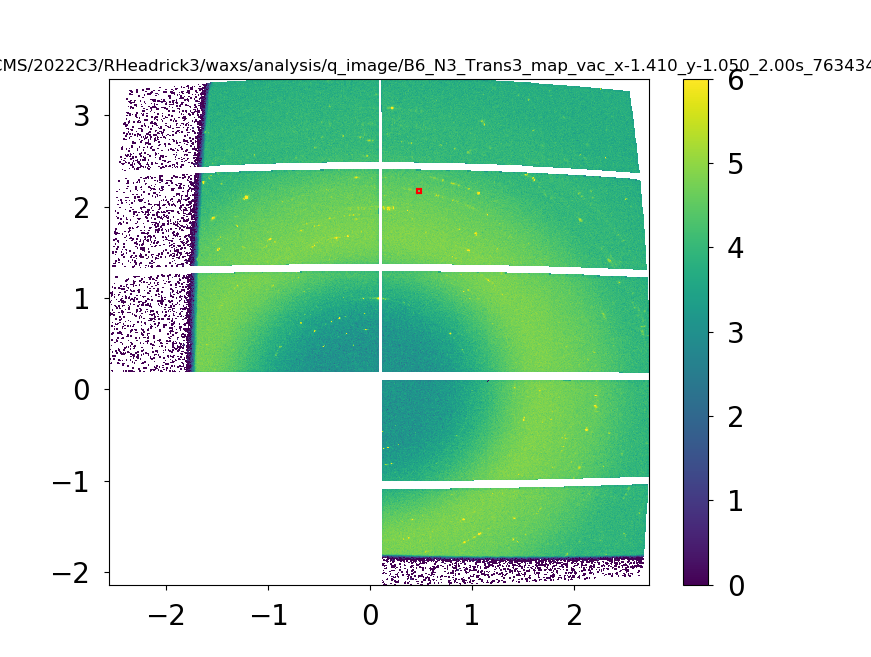

/home/etsai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/home/etsai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log


[ 84.50347588 382.90637509]


Text(0.5, 1.0, '/home/etsai/BNL/Users/CMS/2022C3/RHeadrick3/waxs/analysis/q_image/B6_N3_Trans3_map_vac_x-1.410_y-1.050_2.00s_763434_waxs.npz')

In [22]:
#%matplotlib nbagg

#output_dir = '/nsls2/data/cms/legacy/xf11bm/data/2022_3/RHeadrick3/waxs/analysis/'
output_dir = '/home/etsai/BNL/Users/CMS/2022C3/RHeadrick3/waxs/analysis/'
infile = output_dir+'q_image/B6_N3_Trans3_map_vac_x-1.410_y-1.050_2.00s_763434_waxs.npz'
print(infile)

data = np.load(infile)
#print(list(data))

image = data['image']
x_axis = data['x_axis']
y_axis = data['y_axis']
x_scale = data['x_scale']
y_scale = data['y_scale']


##### Can plot in log or not; Adjust cmap for colormap, clim for plot range
plt.figure(); 
plt.pcolormesh(x_axis, y_axis, np.log(image), cmap='viridis') #plot in log intensity

plt.colorbar()
plt.clim([0, 6])

[qx, qz] = [0.48, 2.175]
[dqx, dqz] = [0.02, 0.02]
plt.plot([qx-dqx, qx+dqx], [qz-dqz, qz-dqz], 'r-')
plt.plot([qx-dqx, qx+dqx], [qz+dqz, qz+dqz], 'r-')
plt.plot([qx-dqx, qx-dqx], [qz-dqz, qz+dqz], 'r-')
plt.plot([qx+dqx, qx+dqx], [qz-dqz, qz+dqz], 'r-')

print([qx, qz] /x_scale)
plt.title(infile)

### &#9632;  A5.2 Extract analysis results from .XML to .TXT and .NPY
 
 E.g. fitting parameters (output from runX.py) are saved in ./analysis/results/*.xml
 
 For one or multiple measurements, this script load the .XML and save it to .TXT and .NPY

In [ ]:
## Functions for extracting results from xml files
########################################
from SciAnalysis.Result import * # Results() object
def extract_results(infiles, extractions, outfile, verbosity=3):
    if verbosity>=3: print("Extracting results for {} infiles...".format(len(infiles)))   
    results = Results().extract_multi_save_txt(outfile, infiles, extractions, verbosity=verbosity)
    
    return results

def load_file(infile, verbosity=3):
    if verbosity>=3:
        print(" Loading data from file: {}".format(infile))
    
    with open(infile, 'r') as fin:
        names = fin.readline().split()
        lines = fin.readlines()

    if verbosity>=4:
        print('  Saved data has {} columns:'.format(len(names)))
        print(names)
        
    return names, lines


# Files to analyze
########################################
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2021_2/SSenanayak/waxs/'
verbosity = 3

source_dir = EXPR_DIR + 'stitched_analysis_test/'
output_dir = EXPR_DIR + 'stitched_analysis_test/'

pattern = 'NT' 

## Extract results from XML files
results_dir = source_dir + 'results/' # Location of xml files
infiles = glob.glob(os.path.join(results_dir, '{}*.xml'.format(pattern)))
outfile = os.path.join(output_dir, '{}-extracted.txt'.format(pattern))


extractions = [ #[ 'metadata_extract', ['x_position', 'y_position', 'sequence_ID', 'anneal_time'] ] ,
            ['circular_fit_compare3', ['fit_peaks_prefactor1', 'fit_peaks_x_center1', 'fit_peaks_sigma1', 'fit_peaks_chi_squared', 'fit_peaks_d0', 'fit_peaks_grain_size' ] ],
            ]    

results = extract_results(infiles, extractions, outfile=outfile, verbosity=verbosity)


## Export results of interest to an array
names, lines = load_file(outfile, verbosity=verbosity)

columns = [
    #'metadata_extract__x_position', 
    #'metadata_extract__y_position', 
    #'metadata_extract__anneal_time',
    'circular_fit_compare3__fit_peaks_chi_squared'
    ]

indices = [names.index(col) for col in columns]

data = []
for i, line in enumerate(lines):
    line = line.split()
    if len(line)>=len(indices):
        row = [ float(line[i]) for i in indices ]
        data.append(row)

print('\n----- Output array:\n {}'.format(data))
        
## Save 
if 0: 
    outfile = os.path.join(output_dir, '{}-{:d}.npy'.format(pattern, len(data)))
    np.save(outfile, data)
    if verbosity>=3:
        print('  Saved data as'.format(outfile))

        
    

### &#9632;  A5.3 Load ROI

In [14]:
import pandas as pd

## Get infile
#pattern = 'B6_N3_Trans3_map_vac_x-0.006_y-1.050_2.00s_763448_waxs'
pattern = 'B6_N3_Trans3_map_vac_x-1.410_y-1.050_2.00s_763434'
infiles = glob.glob(os.path.join(output_dir+'/roi/', pattern+'*.txt')); 
print('Plotting {} infiles...'.format(len(infiles)))

## Load 
stats_list = []
for nn, infile in enumerate(infiles):
    data =  pd.read_table(infile, delimiter = ' ', header=None)
    if nn==0: print(data)
        
    temp = []
    for ii in np.arange(3,13):
        temp.append(data[2][ii])
    stats_list.append(temp)

    
stats_array = np.asarray(stats_list)


## Plot 
#%matplotlib tk
plt.rcParams['figure.figsize'] = [10, 5] #[height, width] of the figure

for ii in np.arange(0,stats_array.shape[1]):
    plt.plot(stats_array[:,ii])


Plotting 1 infiles...
                0  1            2
0              qx  :     0.500000
1             dqx  :     0.020000
2              qz  :     2.200000
3             dqz  :     0.020000
4       stats_max  :   118.000000
5       stats_min  :    68.000000
6   stats_average  :    92.482143
7       stats_std  :     9.699026
8         stats_N  :    56.000000
9     stats_total  :  5179.000000
10     stats_skew  :     0.262279
11   stats_spread  :    50.000000
12  stats_std_rel  :     0.104875


# &#9635; Section B: Experiment

## (Map plot for RHeadrick3)

All analysis results are saved in the __output_dir__. You can view the results there directly. 

To compare multiple measurements, define an __experiment__ (series of measuremeants) and load/plot results here. This useful if you want to do comparison over many measurements, or to navigate the q positions on the plots etc. __The experiment class is defined in SciAnalysis/ExpAnalysis/Experiment.py__


In [1]:
#%matplotlib nbagg

# Imports
########################################
import sys, os, time, glob, imageio
from silx.io.dictdump import dicttoh5, h5todict

#SciAnalysis_PATH='/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/' ### Specify this
SciAnalysis_PATH = '/home/etsai/BNL/Users/software/SciAnalysis/'
SciAnalysis_PATH in sys.path or sys.path.append(SciAnalysis_PATH)

from SciAnalysis.XSAnalysis.Data import *
from SciAnalysis.ExpAnalysis import Experiment
from SciAnalysis.ExpAnalysis import Tools

## &#9632; B.1 Define Experiment (one or multiple series of measurement)

### B1.1 Define and load files

1. Specify experiment directory, e.g. '/nsls2/data/cms/legacy/xf11bm/data/2022_3/RHeadrick3'

2. Specify samples to compare, use regular expression (https://regexr.com/), e.g. 'LL_X' will load samples LL_X1, LL_X2 and so on; 'LL_X.+pos1' will load samples with filenames LL_X*pos1



In [2]:
#EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2022_3/RHeadrick3' ### CHANGE THIS
EXPR_DIR = '/home/etsai/BNL/Users/CMS/2022C3/RHeadrick3/'

exp = Experiment.experiment('B6_map', folder=EXPR_DIR, det='waxs', beamline=None) ### CHANGE THIS, this expriment name can be arbitrary 
exp.samples = ['B6_N3_Trans3_map_vac_x-1'] ### Specify the sample

for sample in exp.samples:
    #exp.defFiles_query(fn=sample, folder=EXPR_DIR, scanid = [750000, 900000], verbose=1) 
    exp.defFiles(fn=sample, verbose=1) 
   
    

/home/etsai/BNL/Users/CMS/2022C3/RHeadrick3/waxs/raw/
Loaded 690 files.


### B1.2 Get metadata

We can either extract metadata from the filename, or read from the databse. Currently it is easier to extract from filename if not working at the beamline. 

#### &#9656; Extract 'metadata' from filename

In [3]:
infiles = exp.dict['expinfo']['filename']
print('Number of files: {}'.format(len(infiles)))

sample_x = []
sample_y = []
scan_id = []
for ii, infile in enumerate(infiles):
    temp = infile.split('_')
    if ii==0: print(temp)
    sample_x.append(float(temp[-4][1:]))
    sample_y.append(float(temp[-3][1:]))
    scan_id.append(int(temp[-1]))

exp.dict['metadata']['sample_x'] = np.array(sample_x)
exp.dict['metadata']['sample_y'] = np.array(sample_y)
exp.dict['metadata']['scan_id'] = np.array(scan_id)

Number of files: 690
['B6', 'N3', 'Trans3', 'map', 'vac', 'x-1.907', 'y-1.800', '2.00s', '762679']


In [ ]:
if 0:  # For testing 
    print(infiles[0])
    temp = infiles[0].split('_')
    print(temp)
    x = float(temp[-4][1:])
    print(x)

&#9656; Or, load metadata from h5 if available. Note this is for the selective dataset not complete database. DSSI is working on exporting the database.

In [ ]:
h5_path = EXPR_DIR+"/data/"
h5_file = 'B6_N3_Trans3_map_vac_x-1_metadata.h5'
exp.dict['metadata'] = h5todict(h5_path+h5_file)

#### [Currently only available at beamline workstation]  
&#9656; If you don't know the metadata you have/need:

In [ ]:
if 0:  # Set to 1 if you don't know the metadata you have/need
    exp.listMetadata(verbosity=3)
    exp.listMetadata(verbosity=-1) 

&#9656; Or specify the metadata directly

In [ ]:
exp.dict['mdata_list'] = ['filename', 'scan_id', 'sample_x', 'sample_y'] # Load x and y positions for each measurement
exp.loadMetadata() 
#exp.dict['mdata_list'])

&#9656; Save metadata (as h5) 

In [ ]:
h5_path = EXPR_DIR+"/data/"
h5_file = exp.samples[0]+'_metadata.h5'
dicttoh5(exp.dict['metadata'], h5_path+h5_file)
print(h5_path+h5_file)


### B1.3 Load analysis data

#### Load all analysis by default or e.g. have keys=['circular_average', 'linecut_angle_fit']

In [4]:
exp.loadSciAnalysisData(keys = ['linecut_angle_fit'], verbose=1) # Load all analysis by default, or have keys=[]
exp.dict['data'].keys()


analysis_folder = /home/etsai/BNL/Users/CMS/2022C3/RHeadrick3//waxs/analysis/
[0%] 
[29%] 
[58%] 
[87%] 
loadSciAnalysisData time = 15.2s


dict_keys(['linecut_angle_fit'])

In [ ]:
exp.loadSciAnalysisData(keys = ['roi'], verbose=1) # Load all analysis by default, or have keys=[]
exp.dict['data'].keys()

## &#9632; B.2 Visualization

### B2.1 Plot 2D Color Image

#### For plotting mapping results, load the x and y positions from the metadata (specified and loaded in B1.2)

In [ ]:
x_pos = exp.dict['metadata']['sample_x']
y_pos = exp.dict['metadata']['sample_y']
print('Len(y_pos) = {}'.format(len(y_pos)))

#### Load the analysis (reduced) data, e.g. load the linecut (of specific q) and define feature as the angle at which the peak max occurs, it can also be the max peak intensity, roi intensity etc. This section should be modified to output some 'feature' that you want to visualize its map.

&#9656; Example 1: load linecut and find the angle with max peak intensity

In [ ]:
reduced_data = exp.dict['data']['linecut_angle_fit']
print('Len(reduced_data) = {}'.format(len(reduced_data)))

feature_list = []
for ii in np.arange(0,len(reduced_data)):
    angle = reduced_data[ii]['angle']
    I = reduced_data[ii]['I']
    chi = angle[np.argmax(I)]
    feature_list.append(chi)


&#9656; Example 2: load roi

In [ ]:
reduced_data = exp.dict['data']['roi']
print('Len(reduced_data) = {}'.format(len(reduced_data)))
print(reduced_data.keys())

#reduced_data['stats_average'][0]

feature_list = []
for ii in np.arange(0,len(reduced_data)):
    feature_list.append(reduced_data['stats_average'][ii])

#### Plot option 1

In [ ]:
## If plot does not show up, enable this nbagg once and try again then disable
%matplotlib nbagg 

plt.figure(); plt.clf()

#plt.tripcolor(x_pos, y_pos, feature_list)  
plt.tricontourf(x_pos, y_pos, feature_list) 
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title(exp.samples[0])
plt.axis('equal')
#plt.plot(x_pos, y_pos, 'w.')

#### Plot option 2

In [ ]:
## If plot does not show up, enable this nbagg once and try again then disable
#%matplotlib nbagg 

plot_interp = ['linear', 0.01] 
x_pos_fine, y_pos_fine, feature = Tools.interp_map(x_pos, y_pos, feature_list, plot_interp) 

plt.figure(); 
extent = (np.nanmin(x_pos_fine), np.nanmax(x_pos_fine), np.nanmin(y_pos_fine), np.nanmax(y_pos_fine))

plt.imshow(feature, extent=extent, origin='lower', cmap='jet', clim=[-180, 180])  
plt.colorbar()
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.title(exp.samples[0])

#### Plot option 3 (Quiver plot)

In [ ]:
u_list = []
v_list = []
for chi in feature_list:
    u = np.cos(np.deg2rad(chi)) 
    v = np.sin(np.deg2rad(chi)) 
    u_list.append(u)
    v_list.append(v)
        

In [ ]:
fig, ax = plt.subplots(figsize=[8,6])

q = ax.quiver(x_pos, y_pos, u_list, v_list, chi_list, cmap = 'plasma') #,clim=[0,0.3])

#ax.set_xlim([-0.2,5])
#ax.set_ylim([-0.2,5])
ax.axis('equal')
ax.set_xlabel('$x$ (mm)')
ax.set_ylabel('$y$ (mm)')
cb = plt.colorbar(q)
plt.show()
plt.title(exp.samples[0])
# plt.savefig('SAXS mapping_quiver polt_colorbar.png', dpi = 600)



In [ ]:
exp.dict['data'].keys()

## &#9632; B.3 Export dictionary to h5

#### Save metadata to h5

In [ ]:
print(EXPR_DIR)
h5_path = EXPR_DIR+"/data/"
h5_file = 'metadata.h5'
dicttoh5(exp.dict, h5_path+h5_file)

In [ ]:
exp.dict['metadata']

#### Save experiment to h5

In [ ]:
print(EXPR_DIR)
h5_path = EXPR_DIR+"/data/"
h5_file = 'test.h5'
dicttoh5(exp.dict, h5_path+h5_file)

#### Read a h5 file to a python dictionary

Note that indices are load as strings, not full recovery from dict-->h5-->dict

In [ ]:
h5_path = EXPR_DIR+"/data/"
h5_file = 'test.h5'
test = h5todict(h5_path+h5_file)

In [ ]:
test

In [ ]:
#dicttoh5?

In [ ]:
# dicttoh5(exp.dict, "test.h5", h5path=EXPR_DIR+"/data/", mode = 'w')